## Imports

In [1]:
# Core Packages
import os
import json

# Third Party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.calibration import calibration_curve
from sklearn import metrics

In [2]:
# Our code (autoreload)
%load_ext autoreload
%autoreload 2
import utils.credit as utils

In [3]:
# High-res plots
%config InlineBackend.figure_format = 'retina'

## AIDA System Objective

In [4]:
def gross_profit_rate(approval_rate, default_rate, revenue=10, cost=100):
    return approval_rate * (revenue * (1 - default_rate) - cost * default_rate)

approval_rates = np.linspace(0, 1, 100)
default_rates = np.linspace(0, 0.2, 100)
grid_approval, grid_defaults = np.meshgrid(approval_rates, default_rates, sparse=True)
profit_grid = gross_profit_rate(grid_approval, grid_defaults)

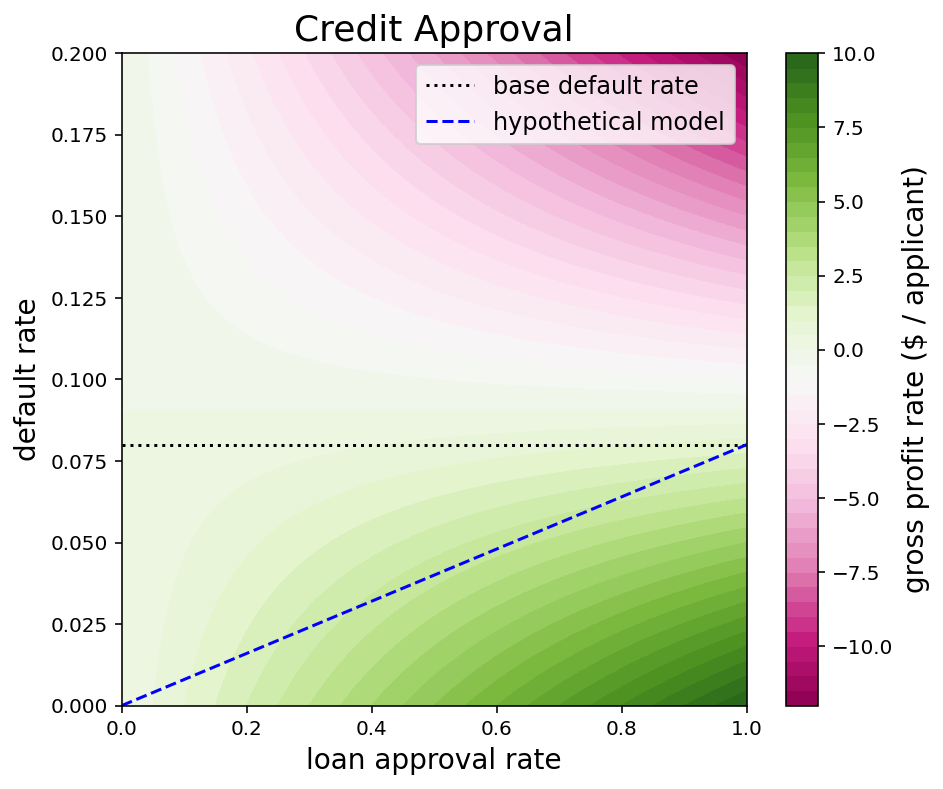

In [5]:
# Visualize
plt.figure(figsize=(7, 6))
profit_lns = plt.contourf(approval_rates, default_rates, profit_grid, cmap='PiYG', levels=50)
plt.title('Credit Approval', fontsize=18)
plt.xlabel('loan approval rate', fontsize=14)
plt.ylabel('default rate', fontsize=14)
plt.axhline(0.08, c='black', ls=':', label='base default rate')
plt.plot([0, 1], [0, 0.08], label='hypothetical model', ls='--', c='grey')
cbar = plt.colorbar(profit_lns)
cbar.set_label('gross profit rate ($ / applicant)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

## Load Data

In [6]:
# Extraneous columns (as determined through basic feature selection)
drop_cols = ['SK_ID_CURR','NAME_TYPE_SUITE','DAYS_EMPLOYED','AMT_CREDIT','AMT_INCOME_TOTAL', 'CC_LATE_PAYMENT_SUM',
             'EXT_SOURCES_WEIGHTED', 'GROUP_INCOME_STD','BUREAU_CREDIT_ACTIVE_Active_MEAN',
             'BUREAU_ACTIVE_DAYS_CREDIT_MEAN', 'BUREAU_CLOSED_DAYS_CREDIT_MAX','BUREAU_CLOSED_DAYS_CREDIT_VAR', 
             'BUREAU_CLOSED_STATUS_12345_MEAN', 'LATE_PAYMENT_SUM', 'CC_SK_DPD_MEAN', 'BUREAU_CREDIT_ACTIVE_Sold_MEAN']

# Load into Dataframes
X_train, y_train = utils.load_dataset(os.path.join('data', 'creditdata', 'creditdata_train_v1.csv'), drop_columns=drop_cols)
X_test, y_test = utils.load_dataset(os.path.join('data', 'creditdata', 'creditdata_test_v1.csv'), drop_columns=drop_cols)

# Metadata for categorical values
with open(os.path.join('data', 'creditdata', 'creditdata_meta_v1.json')) as f:
    label_map = json.load(f)

In [7]:
# Base default rates
print(f"Number of features: {len(X_train.columns)}")
print(f"Train set length: {len(y_train)}, default rate: {round(1 - np.mean(y_train), 4)}")
print(f"Test set length: {len(y_test)}, default rate: {round(1 - np.mean(y_test), 4)}")

Number of features: 36
Train set length: 246004, default rate: 0.0808
Test set length: 61502, default rate: 0.0805


In [8]:
# Categorical feature maping
print("Categorical label mapping:")
for key, values in label_map.items():
    print(key, "--", ", ".join([f"'{val}':{i}" for i, val in enumerate(values)]))

Categorical label mapping:
AGE_RANGE -- '26-64':0, '<=25':1, '>=65':2
CNT_CHILDREN -- '0':0, '1-2':1, '3-6':2, '>7':3
CODE_GENDER -- 'M':0, 'F':1
DAYS_EMPLOYED -- '<2.5k':0, '>2.5k':1
NAME_CONTRACT_TYPE -- 'Cash loans':0, 'Revolving loans':1
NAME_EDUCATION_TYPE -- 'High Education':0, 'Low Education':1
NAME_FAMILY_STATUS -- 'Unmarried':0, 'Married':1
NAME_INCOME_TYPE -- 'Working':0, 'State servant':1, 'Commercial associate':2, 'Pensioner':3, 'Unemployed':4, 'Student':5, 'Businessman':6, 'Maternity leave':7
NAME_TYPE_SUITE -- 'Unaccompanied':0, 'Accompanied':1


## Train Model

In [9]:
# Use best parameters
best_regularizer = 1e-3
best_th = 0.5
model = utils.train_log_reg_model(X_train, y_train, seed=0, C=best_regularizer, upsample=True, verbose=True)

upsampling...
scaling...
fitting...
C: 0.001
chaining pipeline...
done.


## Test Performance

In [10]:
# Get prediction probabilities and predictions at risk threshold
def prob_of_good(model, X):
    return model.predict_proba(X)[:, 1] # prob of resolve (good)

test_probs = prob_of_good(model, X_test)
assert (max(test_probs) < 1) and (max(test_probs) > 0)

test_preds = np.where(test_probs > best_th, 1, 0)

In [11]:
# Simple computation
test_bal_acc = metrics.balanced_accuracy_score(y_test, test_preds)
print(f"Balanced accuracy on test set {round(test_bal_acc, 5)} at threshold {round(best_th, 5)}")

Balanced accuracy on test set 0.65315 at threshold 0.5


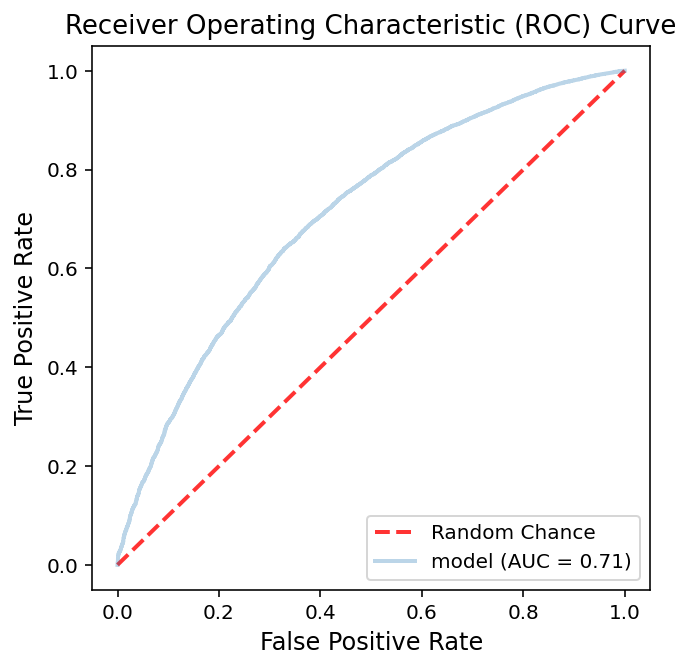

In [12]:
def plot_roc(model, X, y):
    figure = plt.figure(figsize=(5,5))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Random Chance', alpha=.8)
    metrics.plot_roc_curve(model, X, y, name='model', alpha=0.3, lw=2, ax=plt.gca())
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=13)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.show()

plot_roc(model, X_test, y_test)

In [13]:
# Bootstrap uncertainty analysis

# Metrics based on predictions
prediction_metrics = {'True Positive Rate (i.e. sensitivity, or recall)': metrics.recall_score,
                      'True Negative Rate (i.e. specificity)': lambda x, y: metrics.recall_score(x, y, pos_label=0),
                      'Balanced Accuracy': metrics.balanced_accuracy_score,
                      'Positive Predictive Value (precision)': metrics.precision_score}

# Metrics based on probabilities
probability_metrics = {'Area Under ROC': metrics.roc_auc_score}

for name, metric_func in prediction_metrics.items():
    print(name, ":", utils.format_uncertainty(*utils.bootstrap_conf_int(y_test, test_preds, metric_func, k=25)))

for name, metric_func in probability_metrics.items():
    print(name, ":", utils.format_uncertainty(*utils.bootstrap_conf_int(y_test, test_probs, metric_func, k=25)))



True Positive Rate (i.e. sensitivity, or recall) : 0.70056 +/- 0.00292
True Negative Rate (i.e. specificity) : 0.60532 +/- 0.01263
Balanced Accuracy : 0.65429 +/- 0.00720
Positive Predictive Value (precision) : 0.95309 +/- 0.00213
Area Under ROC : 0.70679 +/- 0.00796


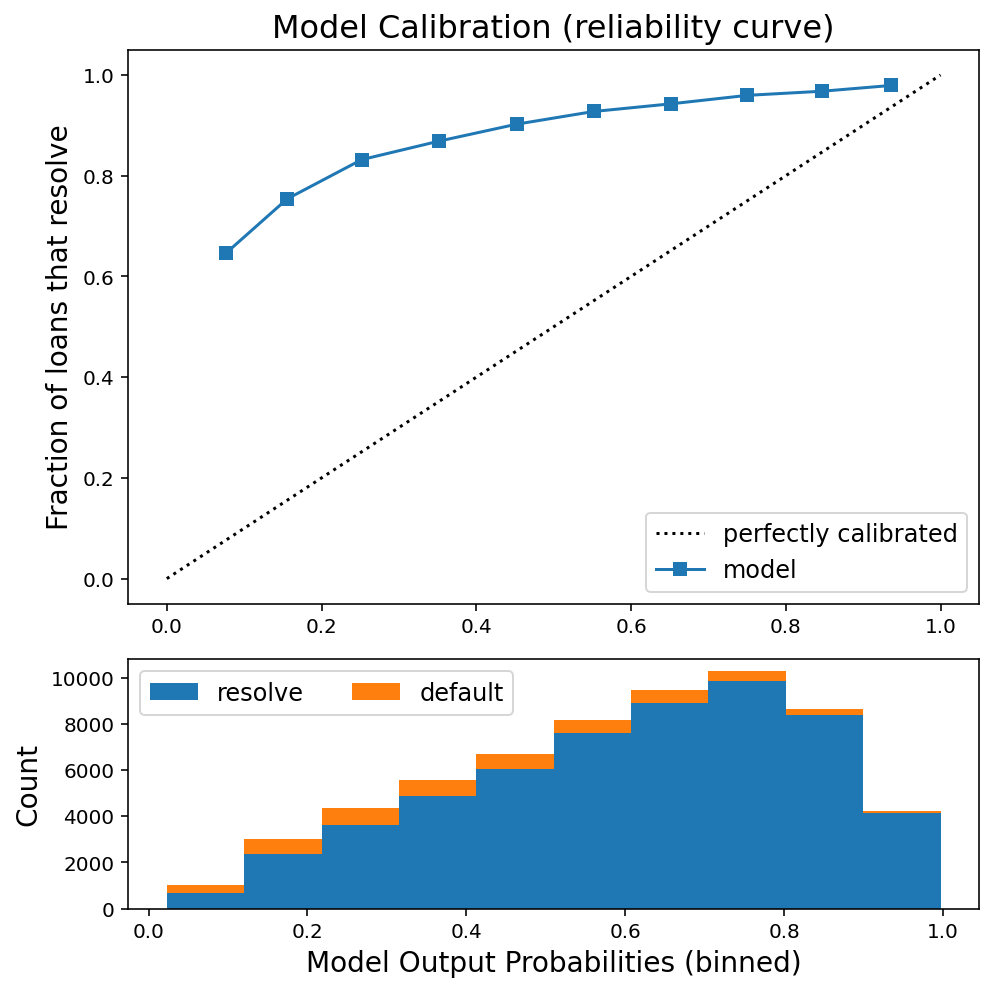

In [14]:
# Calibration curve
def plot_calibration(bin_true_prob, bin_pred_prob):
    plt.figure(figsize=(7, 7))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="perfectly calibrated")
    ax1.plot(bin_pred_prob, bin_true_prob, "s-",
             label="model")

    ax2.hist([test_probs[y_test == 1], test_probs[y_test == 0]], label=["resolve", "default"],
              histtype='bar', stacked=True)

    ax1.set_ylabel("Fraction of loans that resolve", fontsize=14)
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right", fontsize=12)
    ax1.set_title('Model Calibration (reliability curve)', fontsize=16)

    ax2.set_xlabel("Model Output Probabilities (binned)", fontsize=14)
    ax2.set_ylabel("Count", fontsize=14)
    ax2.legend(loc="upper left", ncol=2, fontsize=12)

    plt.tight_layout()
    plt.show()

bin_true_prob, bin_pred_prob = calibration_curve(y_test, test_probs, n_bins=10)
plot_calibration(bin_true_prob, bin_pred_prob)

## Fairness

In [15]:
# Create a gender identifying mask
gender_mask = (X_test["CODE_GENDER"] == 0)  # True: Male, False: Female 
print('Percent Male:', round(np.mean(gender_mask), 5), 'Percent Female:', round(np.mean(~gender_mask), 5))

Percent Male: 0.34085 Percent Female: 0.65915


In [16]:
# Run the analysis
gender_analysis = utils.FairnessAnalysis(y_test, test_probs, gender_mask)
gender_metrics = gender_analysis.compute(best_th)
for attr, name in utils.FairnessAnalysis.metric_names.items():
    print(name, ":", round(getattr(gender_metrics, attr), 5))

Equal Opportunity : -0.12762
False Positive Rate Balance : -0.12058
Average Odds : -0.1241
Demographic Parity : -0.13688
Positive Predictive Parity : -0.01454
Balanced Accuracy : 0.65314


In [17]:
# Bootstrap Uncertainty
bs_metrics = []
np.random.seed(0)
for i in range(25):
    idx = np.random.choice(len(y_test), len(y_test), replace=True)
    bs_metrics.append(utils.FairnessAnalysis(y_test[idx], test_probs[idx], gender_mask[idx]).compute(best_th))

bs_metrics = np.array(bs_metrics)

In [18]:
for i, attr in enumerate(gender_metrics._fields):
    print(utils.FairnessAnalysis.metric_names[attr], ":", utils.format_uncertainty(bs_metrics[:, i].mean(), 2 * bs_metrics[:, i].std()))

Equal Opportunity : -0.12658 +/- 0.00628
False Positive Rate Balance : -0.12458 +/- 0.02997
Average Odds : -0.12558 +/- 0.01490
Demographic Parity : -0.13632 +/- 0.00619
Positive Predictive Parity : -0.01397 +/- 0.00531
Balanced Accuracy : 0.65308 +/- 0.00699


## Performance-Fairness Tradeoffs

In [19]:
# Split Threshold Sweep
th_a = np.linspace(0.3, 0.7, 500)
th_b = np.linspace(0.3, 0.7, 500)
grid_th_a, grid_th_b = np.meshgrid(th_a, th_b, sparse=True)
gender_metrics_split_sweep = gender_analysis.compute(grid_th_a, grid_th_b)

In [20]:
# Find best split threshold
bal_acc_grid = gender_metrics_split_sweep.bal_acc
idx = np.unravel_index(bal_acc_grid.argmax(), bal_acc_grid.shape)
best_th_a, best_th_b = th_a[idx[1]], th_b[idx[0]]
print(f"Best Balanced Accuracy (split): {bal_acc_grid.max():.5f} with Male TH: {best_th_a:.3f}, Female TH: {best_th_b:.3f}")

Best Balanced Accuracy (split): 0.65617 with Male TH: 0.544, Female TH: 0.507


In [21]:
# Find bal accuracy when fairness constrained
constrained_bal_acc = np.copy(bal_acc_grid)
constrained_bal_acc[np.where(gender_metrics_split_sweep.equal_opp <= -0.000)] = 0
idx = np.unravel_index(constrained_bal_acc.argmax(), constrained_bal_acc.shape)
best_con_th_a, best_con_th_b = th_a[idx[1]], th_b[idx[0]]
print(f"Best Fairness-Constrained Balanced Accuracy: {constrained_bal_acc.max():.5f} with Male TH: {best_con_th_a:.3f}, Female TH: {best_con_th_b:.3f}")

Best Fairness-Constrained Balanced Accuracy: 0.65068 with Male TH: 0.468, Female TH: 0.569


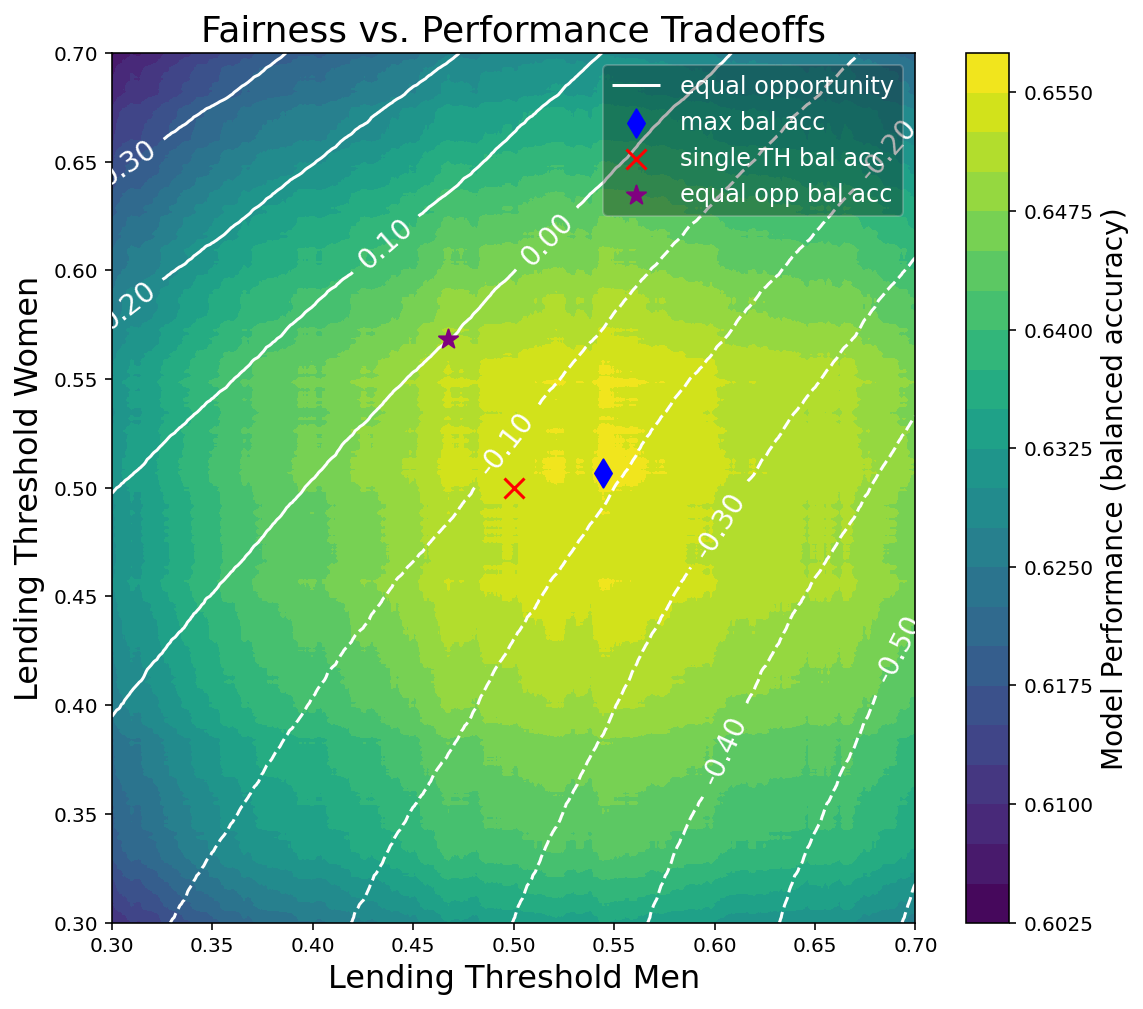

In [22]:
# Plot
plt.figure(figsize=(9,8))
plt.title('Fairness vs. Performance Tradeoffs', fontsize=18)
plt.xlabel('Lending Threshold Men', fontsize=16)
plt.ylabel('Lending Threshold Women', fontsize=16)
plt.xlim(np.min(th_a), np.max(th_a))
plt.ylim(np.min(th_b), np.max(th_b))

bal_acc_lns = plt.contourf(th_a, th_b, gender_metrics_split_sweep.bal_acc, levels=20)

eo_lns = plt.contour(th_a, th_b, gender_metrics_split_sweep.equal_opp, colors='white', levels=10)
eo_lns.collections[-1].set_label('equal opportunity')

cbar = plt.colorbar(bal_acc_lns)
cbar.set_label('Model Performance (balanced accuracy)', fontsize=14)
plt.clabel(eo_lns, inline=1,fmt='%1.2f', fontsize=14)

# Mark maximums
# plt.plot([0, 1], [0, 1], c='gray', ls=':', label='single threshold')
plt.scatter(best_th_a, best_th_b, c='b', marker='d', s=100, label= 'max bal acc', zorder=2)
plt.scatter(best_th, best_th, c='r', marker='x', s=100, label= 'single TH bal acc', zorder=2)
plt.scatter(best_con_th_a, best_con_th_b, c='purple', marker='*', s=100, label= 'equal opp bal acc', zorder=2)
lgnd = plt.legend(framealpha=0.3, facecolor='black', fontsize=12, loc='upper right')
for text in lgnd.get_texts():
    text.set_color("white")
plt.show()

#### Fairness-Performance Tradeoffs (split threshold)
Once the analysis has been run, we can visualize the fairness-performance tradeoffs of operating the model at various lending risk threshold settings. Operating the model at a higher lending risk threshold equates to a lower loan approval rate. The x-axis shows a range of possible lending risk thresholds for men, 
while the y-axis shows a range of possible lending risk thresholds for women. 

The heatmap indicates the model's expected performance (balanced accuracy) when operated at each pair of risk thresholds. Balanced accuracy is the average of the true positive rate (TPR), (i.e. sensitivity, or recall), and the true negative rate (TNR) (i.e. specificity). In our AIDA credit approval system, balanced accuracy is directly proportional to the expected gross profit.

The white contour lines indicate the equal opportunity group fairness metric with respect to gender. Equal opportunity measures the difference in the true positive rates between two groups of individuals, in this case men and women. It is computed as `TPR_men - TPR_women`, thus it is optimal when equal to zero (0). The true positive rate corresponds to the probability that an applicant who would hypothetically repay their loan is accepted by the model.

We plot three points of interest. 
The blue diamond maximizes the unconstrained model performance.
The red X maximizes model performance while keeping the *same* lending risk threshold for both men and women.
The purple star maximizes the model performance while ensuring optimal gender fairness as measured via equal opportunity.

## Personal Attributes

In [23]:
personal_attrs = ['NAME_FAMILY_STATUS', 'CODE_GENDER', 'AGE_RANGE', 'CNT_CHILDREN', 'NAME_EDUCATION_TYPE']

In [24]:
# Leave one out analysis
loo_metrics = []
for i, attr in enumerate(personal_attrs):
    print('\nTraining model without:', attr)
    model_loo = utils.train_log_reg_model(X_train.drop(columns=[attr]), y_train, seed=0, C=best_regularizer, verbose=False)
    
    # Predict and compute fairness Metrics
    loo_test_probs = prob_of_good(model_loo, X_test.drop(columns=[attr]))
    loo_analysis = utils.FairnessAnalysis(y_test, loo_test_probs, gender_mask)
    loo_metrics.append(loo_analysis.compute(best_th))
    
    # Display results as they arrive
    for field, name in utils.FairnessAnalysis.metric_names.items():
        print(name, ":", round(getattr(loo_metrics[i], field), 5))


Training model without: NAME_FAMILY_STATUS
Equal Opportunity : -0.12824
False Positive Rate Balance : -0.1201
Average Odds : -0.12417
Demographic Parity : -0.13789
Positive Predictive Parity : -0.01341
Balanced Accuracy : 0.66037

Training model without: CODE_GENDER
Equal Opportunity : -0.13264
False Positive Rate Balance : -0.12529
Average Odds : -0.12897
Demographic Parity : -0.14184
Positive Predictive Parity : -0.01436
Balanced Accuracy : 0.65276

Training model without: AGE_RANGE
Equal Opportunity : -0.1271
False Positive Rate Balance : -0.11843
Average Odds : -0.12277
Demographic Parity : -0.13627
Positive Predictive Parity : -0.01469
Balanced Accuracy : 0.65382

Training model without: CNT_CHILDREN
Equal Opportunity : -0.1367
False Positive Rate Balance : -0.12303
Average Odds : -0.12986
Demographic Parity : -0.14595
Positive Predictive Parity : -0.01331
Balanced Accuracy : 0.66206

Training model without: NAME_EDUCATION_TYPE
Equal Opportunity : -0.1271
False Positive Rate Bala

In [25]:
# Transform into percent differences
bal_acc_deltas = [100 * (loo.bal_acc - gender_metrics.bal_acc) / gender_metrics.bal_acc for loo in loo_metrics]
equal_opp_deltas = [100 * (loo.equal_opp - gender_metrics.equal_opp) / np.abs(gender_metrics.equal_opp) for loo in loo_metrics]

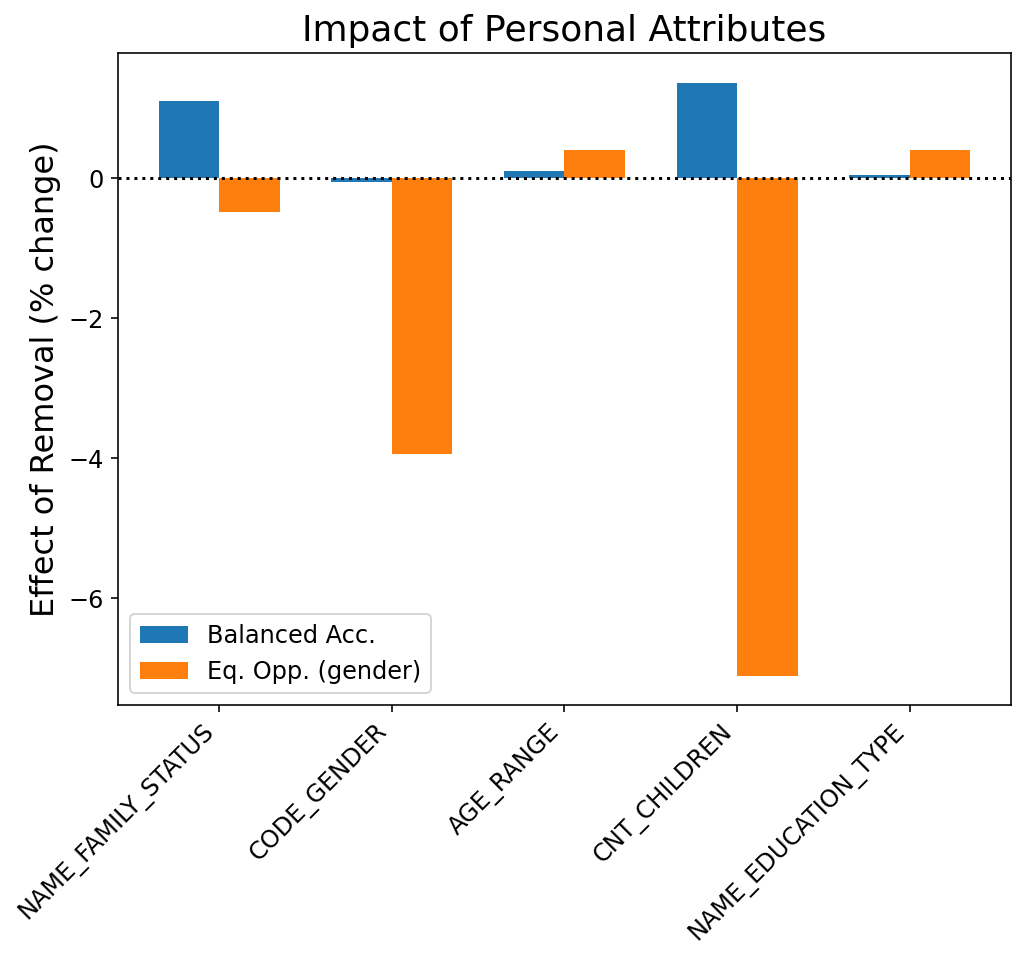

In [28]:
# Plot
plt.figure(figsize=(8,6))
plt.title('Impact of Personal Attributes', fontsize=18)
x = np.arange(len(personal_attrs))  # the label locations
width = 0.35  # the width of the bars
rects1 = plt.bar(x - width/2, bal_acc_deltas, width, label='Balanced Acc.')
rects2 = plt.bar(x + width/2, equal_opp_deltas, width, label='Eq. Opp. (gender)')
plt.axhline(0, c='k', ls=':')
plt.xticks(x, personal_attrs, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Effect of Removal (% change)', fontsize=16)
plt.legend(loc='lower left', fontsize=12)
plt.show()

#### Justifying the use of Personal Attributes
After running a "leave-one-out" feature removal analysis, we can assess the approximate impact of personal attributes on both fairness and model performance. We plot the impact of removing each personal attribute on the model's performance (balanced accuracy) and the equal opportunity group fairness metric with respect to gender. 

Balanced accuracy is the average of the true positive rate (TPR), (i.e. sensitivity, or recall), and the true negative rate (TNR) (i.e. specificity). In our AIDA credit approval system, balanced accuracy is directly proportional to the expected gross profit. Equal opportunity measures the difference in the true positive rates between two groups of individuals, in this case men and women. It is computed as `TPR_men - TPR_women`, thus it is optimal when equal to zero (0). In our model it is currently negative, therefore a positive percent change corresponds to improved fairness. 

We note that the removal of either NAME_FAMILY_STATUS or CNT_CHILDREN has a positive effect on model performance. This indicates that we should consider a more thorough feature selection process. However, their removal also has a negative impact on equal opportunity. This should be considered as a performance-fairness tradeoff.

The removal of CODE_GENDER has a negative impact on the equal opportunity. This emphasizes that "fairness through unawareness" is not sufficient to ensure fair outcomes. Its removal also causes a slight decrease in model performance. Taken together, these impacts may very well justify its inclusion. 

AGE_RANGE and NAME_EDUCATION_TYPE should be strongly considered for exclusion. Their removals have both a slight positive impact on model performance and a positive impact on equal opportunity. 